Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use("seaborn-v0_8")
sns.set_palette("deep")


Load Ames Dataset 

In [ ]:
df = pd.read_csv("../data/AmesHousing.csv")  # update filename if different

print("Shape (rows, columns):", df.shape)
df.head()

print(df.columns[:20])   # first 20 column names
df.info()


Shape (rows, columns): (2930, 82)
Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 n

In [24]:
# Drop ID-like columns
df = df.drop(columns=["Order", "PID"])

# Drop rows with missing SalePrice (just in case)
df = df.dropna(subset=["SalePrice"])

# Fill missing numeric values with median
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values with most frequent value (mode)
for col in df.select_dtypes(include=[object]).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

print("After cleaning, shape:", df.shape)
print("Missing values left:", df.isnull().sum().sum())


After cleaning, shape: (2930, 80)
Missing values left: 0


Step 1: Data Cleaning
We dropped ID columns and handled missing values by filling numeric columns with the median and categorical columns with the mode. After cleaning, the dataset has 2,930 rows and 80 features, with no missing values.


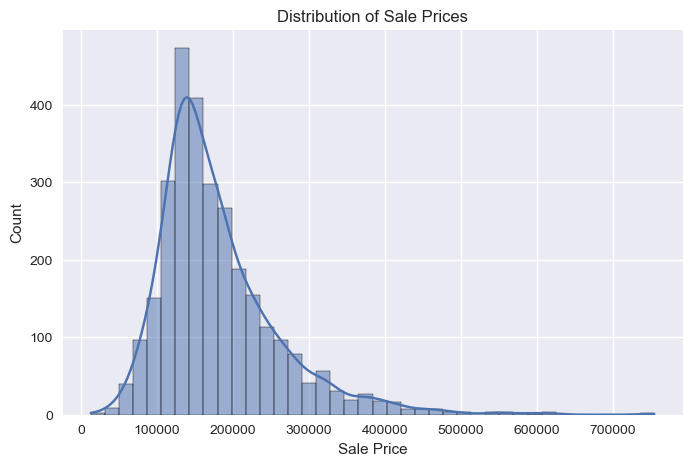

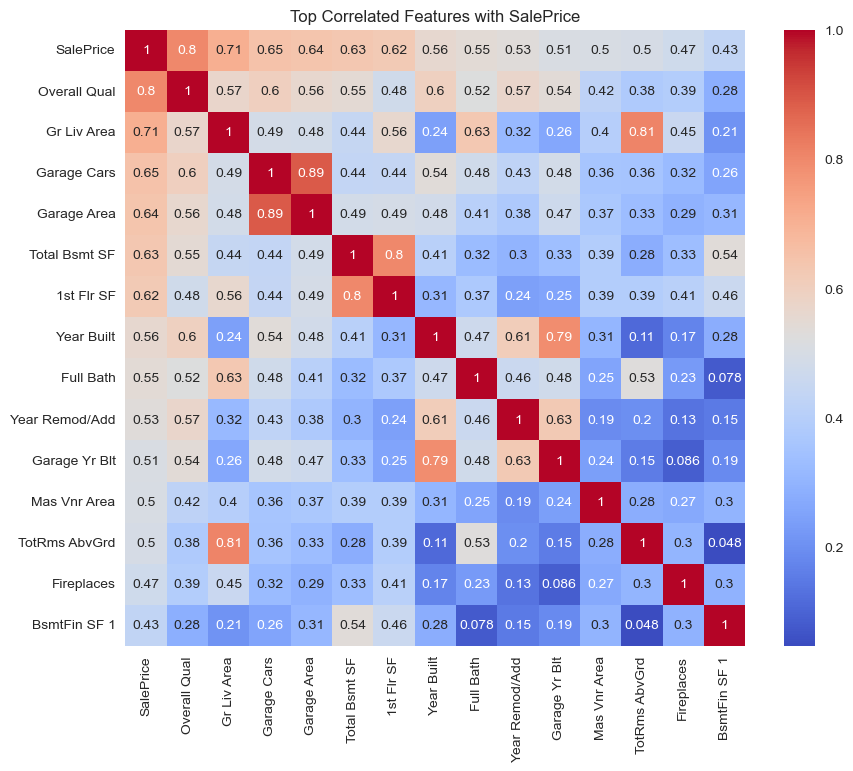

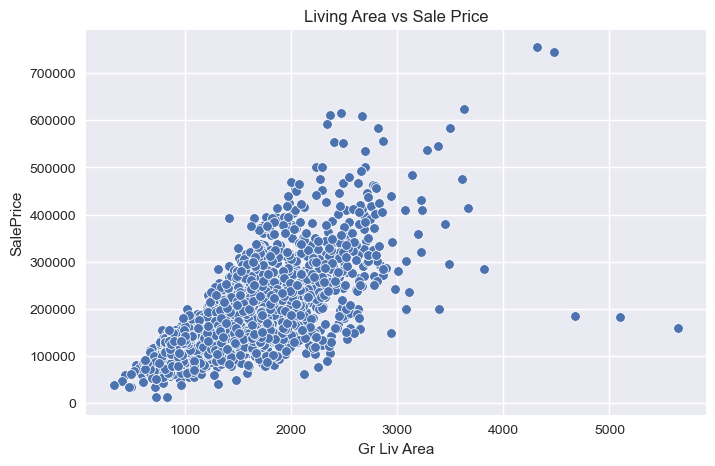

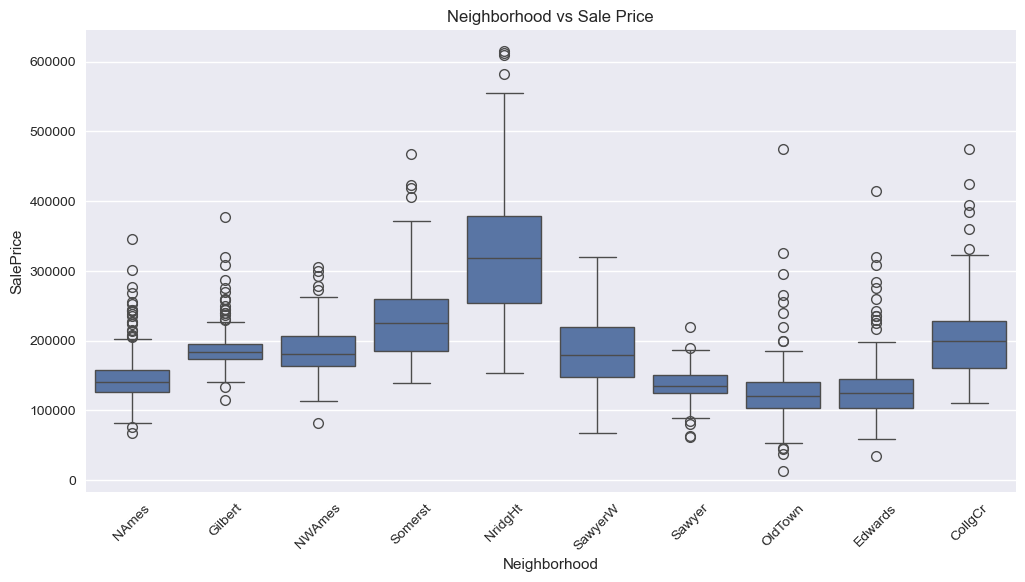

In [ ]:
# Distribution of SalePrice
plt.figure(figsize=(8,5))
sns.histplot(df["SalePrice"], kde=True, bins=40)
plt.title("Distribution of Sale Prices")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show()

# Correlation heatmap (top 15 correlated with SalePrice)
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
top_corr = corr["SalePrice"].sort_values(ascending=False).head(15)
sns.heatmap(df[top_corr.index].corr(), annot=True, cmap="coolwarm")
plt.title("Top Correlated Features with SalePrice")
plt.show()

# Scatterplot: Living Area vs SalePrice
plt.figure(figsize=(8,5))
sns.scatterplot(x="Gr Liv Area", y="SalePrice", data=df)
plt.title("Living Area vs Sale Price")
plt.show()

# Boxplot: Neighborhood vs SalePrice (top 10)
top_neighborhoods = df["Neighborhood"].value_counts().index[:10]
plt.figure(figsize=(12,6))
sns.boxplot(x="Neighborhood", y="SalePrice", data=df[df["Neighborhood"].isin(top_neighborhoods)])
plt.xticks(rotation=45)
plt.title("Neighborhood vs Sale Price")
plt.show()


Step 2: Exploratory Data Analysis (EDA)
- The target variable `SalePrice` is right-skewed, with most homes priced between $100k and $200k.  
- Correlation analysis shows `Overall Qual`, `Gr Liv Area`, `Garage Cars`, and `Year Built` are the strongest predictors of price.  
- Neighborhoods show large differences in median home prices, indicating location is an important factor.


Baseline Model

In [ ]:
# Select a few strong predictors
features = ["Overall Qual", "Gr Liv Area", "Garage Cars", "Year Built"]
X = df[features]
y = df["SalePrice"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Baseline Linear Regression Results:")
print("RMSE:", round(rmse, 2))
print("MAE:", round(mae, 2))
print("R²:", round(r2, 3))

# Coefficients
coeffs = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Coefficients:")
print(coeffs)


Baseline Linear Regression Results:
RMSE: 43339.19
MAE: 28315.09
R²: 0.766

Feature Coefficients:
        Feature   Coefficient
0  Overall Qual  23229.697120
2   Garage Cars  14679.075322
3    Year Built    391.181594
1   Gr Liv Area     55.849151


Step 3: Baseline Model
We trained a simple **Linear Regression** model using four key predictors: `Overall Qual`, `Gr Liv Area`, `Garage Cars`, and `Year Built`.

**Results:**
- RMSE: ~43,339  
- MAE: ~28,315  
- R²: 0.766  

The model explains about 77% of the variance in SalePrice. `Overall Qual` is the strongest driver: each increase of one quality point adds about $23K to predicted price.


Predicted vs Actual & Residuals Plot

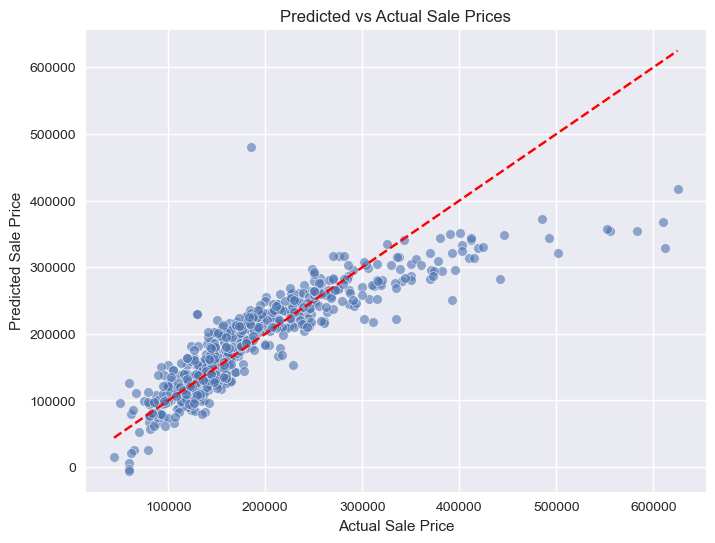

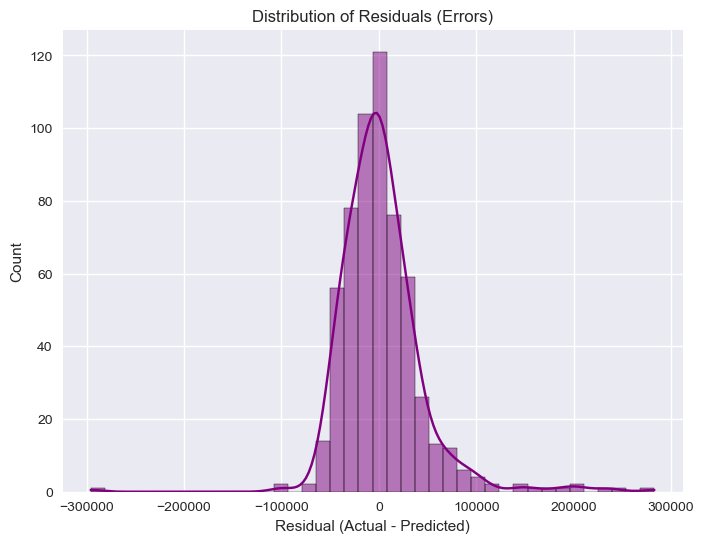

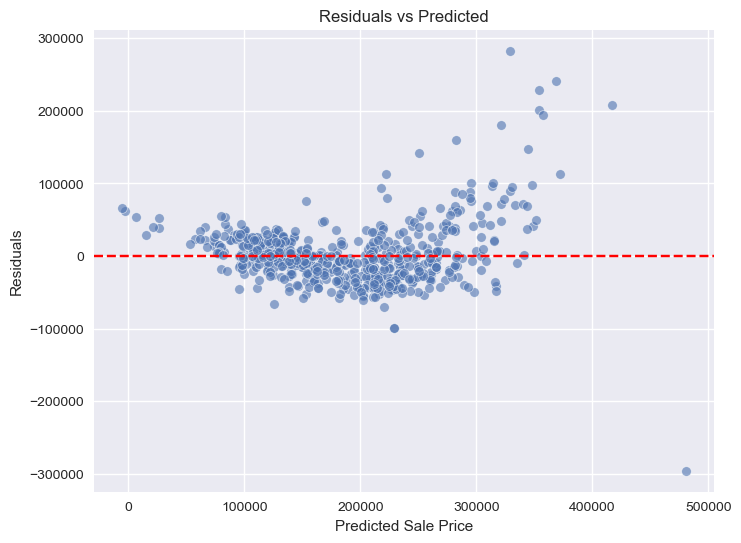

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')  # perfect prediction line
plt.title("Predicted vs Actual Sale Prices")
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=40, color="purple")
plt.title("Distribution of Residuals (Errors)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals")
plt.show()


Step 4: Model Evaluation Plots
- **Predicted vs Actual** shows the model fits well for mid-range homes but underestimates expensive houses.  
- **Residuals Distribution** is centered around 0, with a bell-shaped curve, indicating a mostly unbiased model.  
- **Residuals vs Predicted** reveals greater error spread for higher-priced homes, suggesting linear regression struggles with extreme values.

Next Steps
- Apply transformations (log SalePrice, log skewed features).  
- Encode categorical variables.  
- Try regularized regression (Lasso, Ridge) and tree-based models (Random Forest, Gradient Boosting).